In [1]:
import numpy as np
import h5py
from pathlib import Path
from extra_geom import AGIPD_1MGeometry
from cxiapi import cxiData, calibrateModule, calibrateFixedGainModule
import matplotlib.pyplot as plt
from tqdm import tqdm
from p_tqdm import p_umap, p_map
from functools import partial
import multiprocessing as mp
import cProfile

In [2]:
# Experiment run number.
run = 364
# Hitfinding on which module.
module = 15
# The folder of cxi files
cxi_folder = '/gpfs/exfel/u/scratch/SPB/202130/p900201/spi-comission/vds/'
# Cheetah files folder for calibration
calib_folder = '/gpfs/exfel/exp/SPB/202130/p900201/usr/Software/calib/r0361-r0362-r0363/'
# Geometry file for the detector
geom_file = '/gpfs/exfel/exp/SPB/202130/p900201/usr/Software/geom/agipd_2696_v5.geom'

In [3]:
cxi_path = Path(cxi_folder, f'r{run:04}.cxi')
fn = str(cxi_path)

cxi = cxiData(fn, verbose=1, debug=0)
pulse = np.arange(0, 352)
base_pulse_filter = np.ones(600, dtype="bool")
base_pulse_filter[len(pulse):] = False
base_pulse_filter[0] = False
base_pulse_filter[18::32] = False
base_pulse_filter[29::32] = False
good_cells = pulse[base_pulse_filter[:len(pulse)]]
cxi.setGoodCells(good_cells)
cxi.setCalib(calib_folder)
cxi.setGainMode(0)

VDS file contains 573056 shots
Module 0 contains 352 cells
16 calibration files found


In [4]:
module_index = 15
intens_thresh = 5
adu_per_photon = 45

Text(0.5, 1.0, 'After mask')

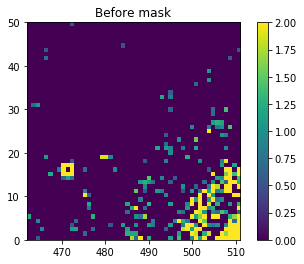

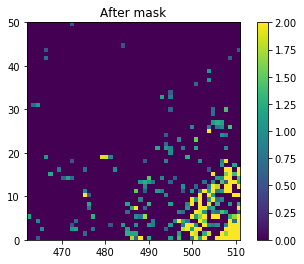

In [5]:
cxi.setGainMode(0)
cxi.setADU_per_photon(adu_per_photon)
# ROI
ROI = (slice(512-50,None), slice(None,51))
cxi.setROI(ROI)
# Mask
cxi.plot(300,module_index,ADU=False,transpose=True)
plt.title('Before mask')

mask = np.ones((512,128))
mask[470:473,15:18] = 0
cxi.setModuleMasks(15,mask)
cxi.plot(300,module_index,ADU=False,transpose=True)
plt.title('After mask')

In [6]:
def getHits(idx_range: list) -> list:
    # Get the index of the hits
    num_cpus = checkChuck(len(idx_range), chuckSize=25000)
    print(f'Using {num_cpus} CPU cores.')
    results = p_umap(partial(check_snapshot,module_index=15), idx_range, num_cpus=num_cpus)
    hits_indices = list(filter((None).__ne__, results))
    return  hits_indices

def getCalibData(cxi_data, snap_idx, module_index):
    n = snap_idx
    data = cxi_data.data
    cell_ids = cxi_data.cellIDs
    calib = cxi_data.calib
    ROI = cxi_data.ROI
    mask = cxi_data.module_masks[str(module_index)]
    adu_per_photon = cxi_data.adu_per_photon

    calib_data = calibrateFixedGainModule(data[n, module_index, 0, :, :],
                                    data[n, module_index,
                                        1, :, :], 0, module_index,
                                    cell_ids[n, 0], calib)
    calib_data = getCalibData(cxi, snap_idx, module_index)
    roi_data = calib_data[ROI]*mask
    nphotons = roi_data / adu_per_photon
    nphotons[nphotons < 0.5] = 0

    return nphotons

def check_snapshot(snap_idx, module_index):
    nphotons = getCalibData(cxi, snap_idx, module_index)
    if intens_thresh < np.log(nphotons.sum()):
        return snap_idx
    
def checkChuck(ntask, chuckSize):
    num_cpu = min(mp.cpu_count(), ntask // chuckSize)
    num_cpu = max(num_cpu, 1)
    return num_cpu

In [7]:
idx_range = cxi.good_frames
hits_indices = getHits(idx_range)

Using 21 CPU cores.


RecursionError: maximum recursion depth exceeded while calling a Python object

Process ForkPoolWorker-8:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-17:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-9:
Process ForkPoolWorker-6:
Process ForkPoolWorker-16:
Process ForkPoolWorker-15:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/juncheng/.local/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-13:
  File "/home/juncheng/.local/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/home/juncheng/.local/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-14:
Process ForkPoolWorker-12:
  File "/home/juncheng/.local/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap